# Step 1: Clone the source code, and install modules

In [1]:
!git clone https://github.com/SalesforceAIResearch/uni2ts.git
%cd uni2ts
!pip install .


Cloning into 'uni2ts'...
remote: Enumerating objects: 899, done.
remote: Counting objects: 100% (414/414), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 899 (delta 268), reused 253 (delta 230), pack-reused 485 (from 1)
Receiving objects: 100% (899/899), 7.15 MiB | 23.10 MiB/s, done.
Resolving deltas: 100% (427/427), done.
/kaggle/working/uni2ts
Processing /kaggle/working/uni2ts
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

# Step 2: Dataset Generator function

In [3]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
import numpy as np

import pandas as pd
import numpy as np

def generate_df(start_date: str, params: list[tuple[float, float, float, float]], std_devs: list[float]) -> pd.DataFrame:
    # Ensure std_devs list matches the length of params
    if len(std_devs) != len(params):
        raise ValueError("Length of std_devs must match the length of params.")
    
    # Create a date range with hourly increments, starting from start_date, with 10,000 entries
    date_index = pd.date_range(start=start_date, periods=10000, freq='H')
    
    # Calculate the hours passed as an integer sequence from 0 to 9999
    hours_passed = np.arange(10000)
    
    # Create a dictionary to store each column based on the (A, k, p, b) parameters and standard deviation
    data = {}  # Start with the 'date' column
    for i, ((A, k, p, b), std_dev) in enumerate(zip(params, std_devs)):
        column_name = f'column{i+1}'  # Naming columns as column1, column2, etc.
        # Generate sinusoidal values and add Gaussian noise
        sinusoidal_values = A * np.sin(k * hours_passed + p) + b
        noise = np.random.normal(0, std_dev, size=hours_passed.shape)
        data[column_name] = sinusoidal_values + noise
    
    # Create DataFrame with date as a column and calculated columns
    df = pd.DataFrame(data, index = date_index)
    return df

# Step 3: Generate Sine Waves
Each wave is defined by a tuple of amplitude, angular frequency, phase shift, and linear shift.

Also add an appropriate noise with standard deviation

In [4]:
def generate_random_params(seed: int, num_tuples: int):
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    # Define reasonable ranges for each parameter
    amplitude_range = (1, 10)       # Range for amplitude A
    frequency_range = (0.02, 0.1)   # Range for angular frequency k
    phase_range = (0, 2 * np.pi)    # Range for phase p
    offset_range = (-5, 5)          # Range for offset b
    std_dev_range = (0.1, 2)        # Range for standard deviation of noise

    # Generate random parameters within specified ranges
    params = []
    std_devs = []
    for _ in range(num_tuples):
        A = np.random.uniform(*amplitude_range)
        k = np.random.uniform(*frequency_range)
        p = np.random.uniform(*phase_range)
        b = np.random.uniform(*offset_range)
        sigma = np.random.uniform(*std_dev_range)
        
        params.append((A, k, p, b))
        std_devs.append(sigma)

    # Print the generated parameters in a neat format
    print("Generated Parameters and Standard Deviations:")
    print("Index | Amplitude (A) | Frequency (k) | Phase (p) | Offset (b) | Std Dev (σ)")
    print("-" * 70)
    for i, ((A, k, p, b), sigma) in enumerate(zip(params, std_devs), start=1):
        print(f"{i:<5} | {A:<13.3f} | {k:<13.3f} | {p:<9.3f} | {b:<10.3f} | {sigma:<10.3f}")
    
    return params, std_devs


seed = 42 
num_tuples = 30 #Number of sine functions
params, std_devs = generate_random_params(seed, num_tuples)
start_date = "2016-07-01 00:00:00"
df = generate_df(start_date, params, std_devs)
print(df)

ds = PandasDataset(dict(df))

Generated Parameters and Standard Deviations:
Index | Amplitude (A) | Frequency (k) | Phase (p) | Offset (b) | Std Dev (σ)
----------------------------------------------------------------------
1     | 4.371         | 0.096         | 4.599     | 0.987      | 0.396     
2     | 2.404         | 0.025         | 5.442     | 1.011      | 1.445     
3     | 1.185         | 0.098         | 5.230     | -2.877     | 0.445     
4     | 2.651         | 0.044         | 3.297     | -0.681     | 0.653     
5     | 6.507         | 0.031         | 1.836     | -1.336     | 0.967     
6     | 8.067         | 0.036         | 3.231     | 0.924      | 0.188     
7     | 6.468         | 0.034         | 0.409     | 4.489      | 1.935     
8     | 8.276         | 0.044         | 0.614     | 1.842      | 0.936     
9     | 2.098         | 0.060         | 0.216     | 4.093      | 0.592     
10    | 6.963         | 0.045         | 3.268     | 0.467      | 0.451     
11    | 9.726         | 0.082         | 5.903 

# Step 4: Use Moirai to make Predictions (512, 96)

In [5]:
import torch
import matplotlib.pyplot as plt
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

# Define Moirai model parameters
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
PDT = 96        # prediction length: any positive integer
CTX = 512       # context length: any positive integer
PSZ = "auto"    # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32        # batch size: any positive integer
TEST = 300      # test set length: any positive integer

# Split into train and test sets
train, test_template = split(ds, offset=-TEST)  # last TEST time steps are test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,    # non-overlapping windows
    distance=PDT
)

model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=PSZ,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=ds.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
)

# Create predictor and forecast
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_list = list(test_data.input)
label_list = list(test_data.label)
forecast_list = list(forecasts)


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

# Step 4: Get the MSE across columns

In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

input_it = iter(input_list)
label_it = iter(label_list)
forecast_it = iter(forecast_list)

total_mse = 0
total_mae = 0
cnt = 0

for inp, label, forecast in zip(input_it, label_it, forecast_it):
    y_true = np.array(label['target'])      # Actual values
    y_pred = np.array(forecast['median'])   # Forecasted mean values

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    cnt += 1
    total_mse += mse
    total_mae += mae

print(total_mse / cnt)
print(total_mae / cnt)


19.70101186118735
3.2883588045465286


# Step 5: Plot the Graphs (For fist few instances)

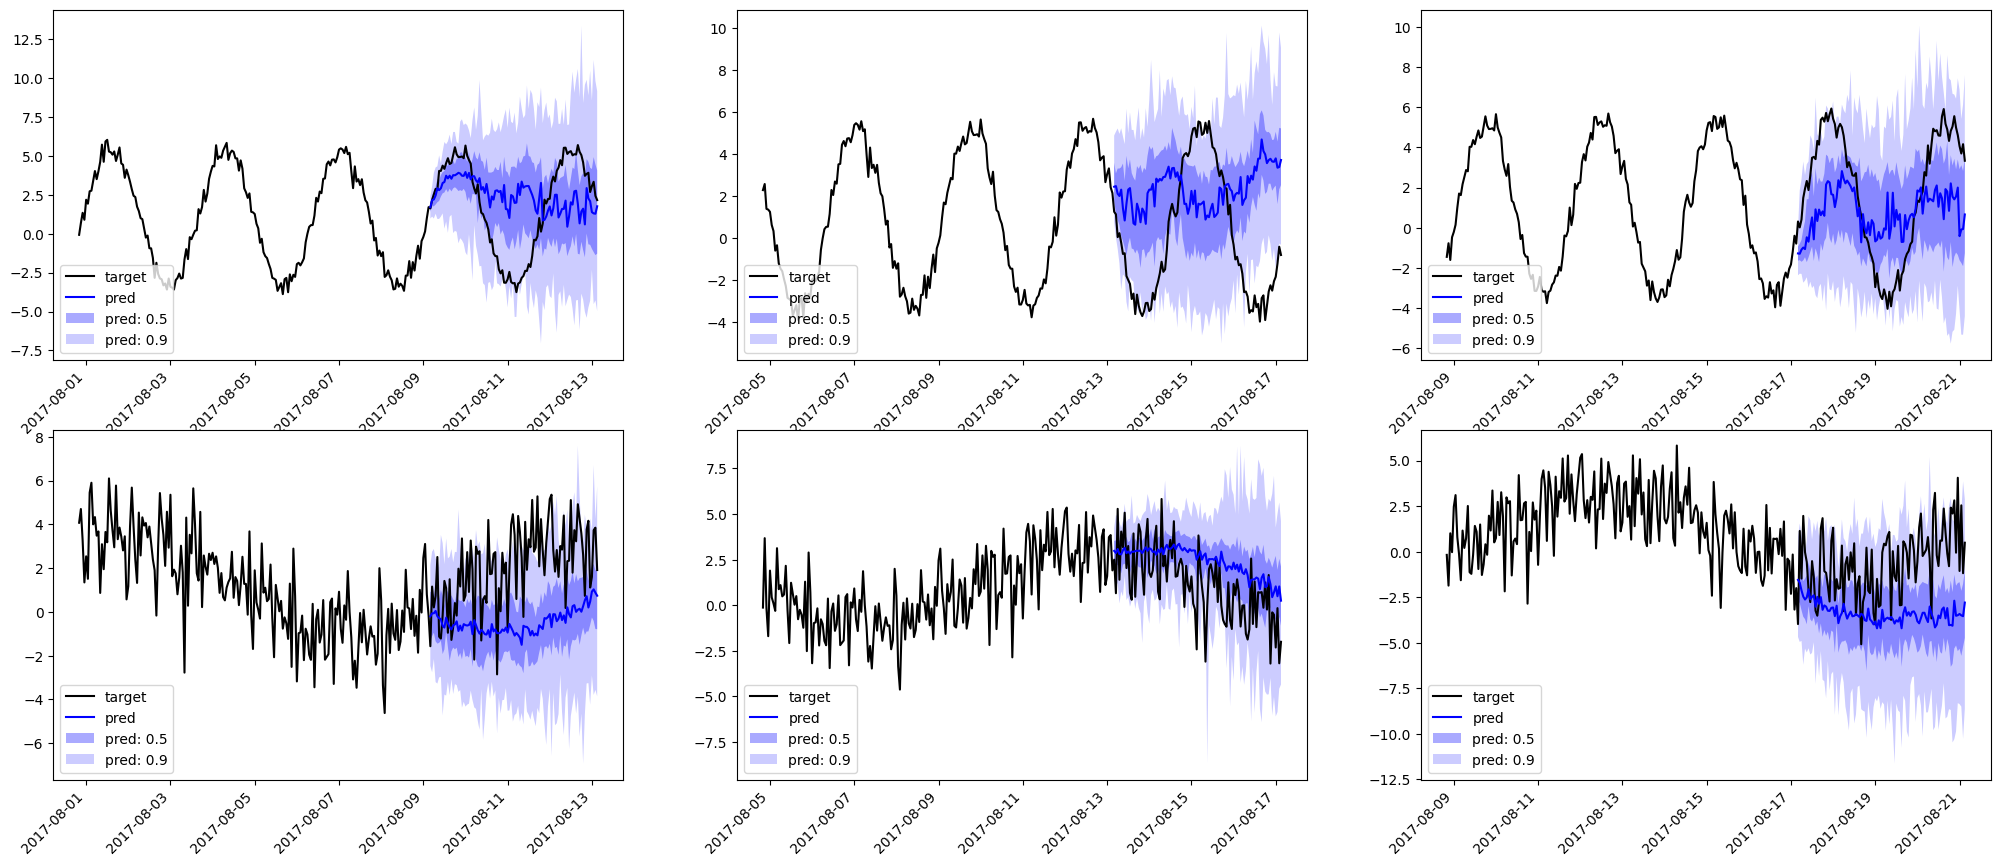

In [7]:
input_it = iter(input_list)
label_it = iter(label_list)
forecast_it = iter(forecast_list)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)